In [ ]:
import numpy as np
import scipy.spatial.distance as distance
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import torch

def get_few_shot_samples(X, y, k):
    """Select k samples per class for few-shot learning."""
    unique_classes = np.unique(y)
    few_shot_X, few_shot_y = [], []
    
    for c in unique_classes:
        class_samples = X[y == c]
        selected_samples = class_samples[:min(k, len(class_samples))]
        few_shot_X.append(selected_samples)
        few_shot_y.append(np.full(len(selected_samples), c))
    
    return np.vstack(few_shot_X), np.hstack(few_shot_y)

class SimpleShot:
    def __init__(self):
        self.class_prototypes = None
        self.classes = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_prototypes = {
            c: np.mean(X[y == c], axis=0) for c in self.classes
        }
    
    def predict(self, X):
        preds = []
        for x in X:
            distances = {c: np.linalg.norm(x - proto) for c, proto in self.class_prototypes.items()}
            preds.append(min(distances, key=distances.get))
        return np.array(preds)

class Retrieval:
    def __init__(self, database, labels):
        self.database = database
        self.labels = labels
    
    def retrieve(self, query, k=5):
        dists = np.linalg.norm(self.database - query, axis=1)
        indices = np.argsort(dists)[:k]
        return self.labels[indices]
    
    def evaluate(self, queries, query_labels, k_vals=[1, 3, 5]):
        acc_at_k = {k: 0 for k in k_vals}
        mvacc_at_5 = 0
        
        for i, query in enumerate(queries):
            retrieved_labels = self.retrieve(query, k=max(k_vals))
            for k in k_vals:
                if query_labels[i] in retrieved_labels[:k]:
                    acc_at_k[k] += 1
            if np.bincount(retrieved_labels[:5]).argmax() == query_labels[i]:
                mvacc_at_5 += 1
        
        num_queries = len(queries)
        return {k: acc_at_k[k] / num_queries for k in k_vals}, mvacc_at_5 / num_queries

def few_shot_experiment(k, X_train, y_train, X_test, y_test):
    """Run few-shot learning experiments for a given k using real dataset."""
    X_few_shot, y_few_shot = get_few_shot_samples(X_train, y_train, k)
    
    # SimpleShot Evaluation
    simpleshot = SimpleShot()
    simpleshot.fit(X_few_shot, y_few_shot)
    y_pred = simpleshot.predict(X_test)
    simpleshot_acc = accuracy_score(y_test, y_pred)
    
    # 20-Nearest Neighbors Evaluation
    knn = KNeighborsClassifier(n_neighbors=20)
    knn.fit(X_few_shot, y_few_shot)
    y_pred_knn = knn.predict(X_test)
    knn_acc = accuracy_score(y_test, y_pred_knn)
    
    # Linear Probing Evaluation
    linear_probe = LogisticRegression(max_iter=1000, C=1.0)
    linear_probe.fit(X_few_shot, y_few_shot)
    y_pred_linear = linear_probe.predict(X_test)
    linear_acc = accuracy_score(y_test, y_pred_linear)
    
    # Retrieval Evaluation
    retrieval = Retrieval(X_few_shot, y_few_shot)
    acc_at_k, mvacc_at_5 = retrieval.evaluate(X_test, y_test)
    
    return {
        "SimpleShot Accuracy": simpleshot_acc,
        "20-NN Accuracy": knn_acc,
        "Linear Probing Accuracy": linear_acc,
        "Retrieval Acc@K": acc_at_k,
        "MVAcc@5": mvacc_at_5
    }


{'val_bacc': 0.242, 'val_weighted_f1': 0.305, 'val_macro_auroc': 0.663, 'val_qwk': 0.321}


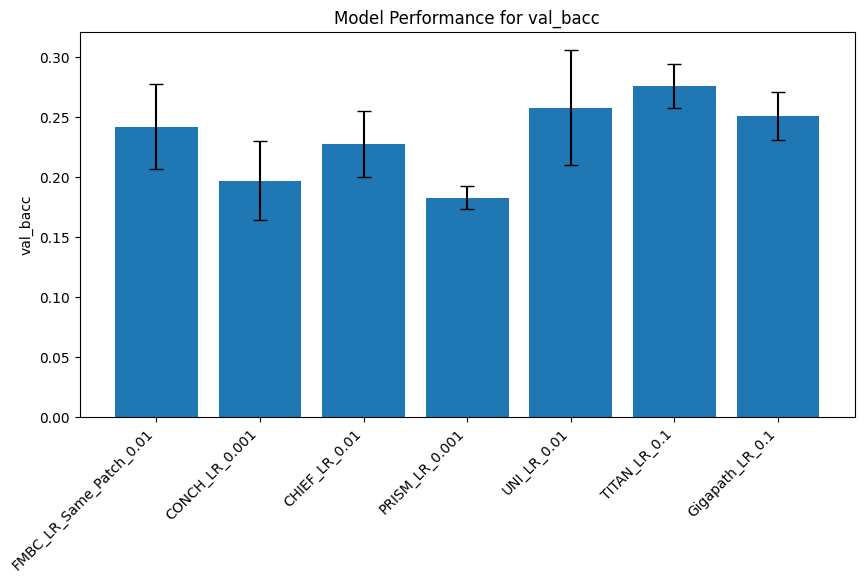

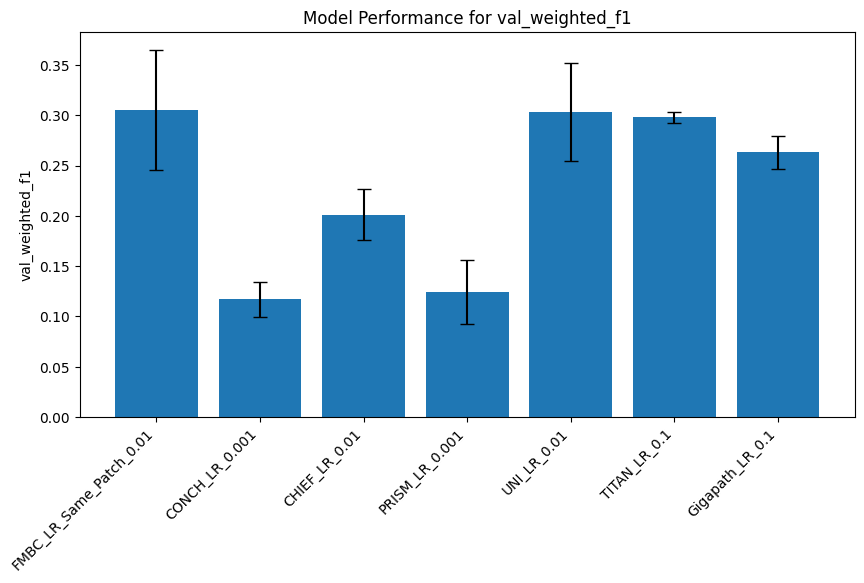

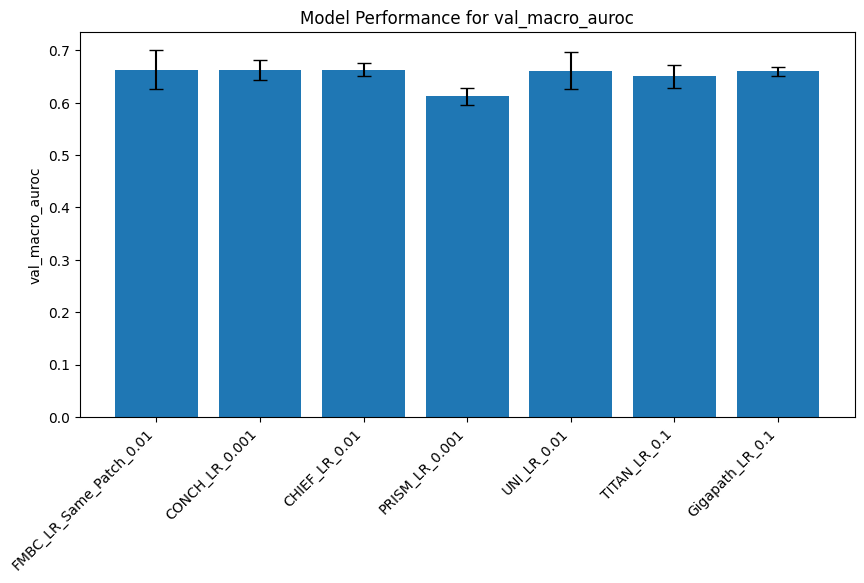

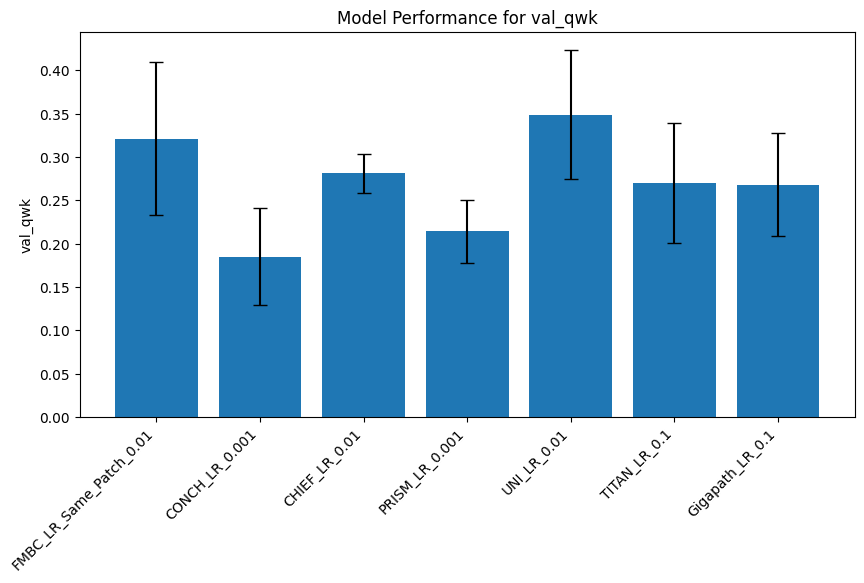

In [22]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def get_result_csv(result_dir):
    evaluation_metrics = ['val_bacc', 'val_weighted_f1', 'val_macro_auroc','val_qwk']
    desired_order = [
        "UNI", "CONCH", "Virchow","Gigapath_Tile",'Gigapath',
        "CHIEF_Tile","TITAN","FMBC"  
    ]

    all_results = []
    for model_name in os.listdir(result_dir):
        for tuning_method in os.listdir(os.path.join(result_dir, model_name)):
            for lr_rate in os.listdir(os.path.join(result_dir, model_name, tuning_method)):
                model_sumary_path = os.path.join(result_dir, model_name, tuning_method,lr_rate, "summary.csv")
                if 'ABMIL' in model_sumary_path:
                    continue
                if os.path.isfile(model_sumary_path):
                    df = pd.read_csv(model_sumary_path)

                    summary_stats = {"Model": model_name+'_'+tuning_method+'_'+lr_rate}
                    for metric in evaluation_metrics:
                        if metric in df.columns:
                            mean_val = np.mean(df[metric])
                            std_val = np.std(df[metric], ddof=1)  # 样本标准差
                            summary_stats[metric] = f"{mean_val:.3f}±{std_val:.4f}"
                    all_results.append(summary_stats)
    final_result_df = pd.DataFrame(all_results)
    final_result_df.style.hide(axis="index")
    #display(final_result_df)
    return final_result_df

def select_best_models(csv,all_metrics, eval_metrics):
    # 读取 CSV
    df = csv
    
    # 提取 FMBC 的最佳行
    fmbc_row = df[df['Model'].str.startswith('FMBC')].iloc[0]
    fmbc_values = {metric: float(fmbc_row[metric].split('±')[0]) for metric in all_metrics}  # 取均值部分
    print(fmbc_values)
  
    selected_rows = [fmbc_row]
    unique_models = set(row.split('_')[0] for row in df['Model'] if not row.startswith('FMBC'))
    
    for model in unique_models:
        model_rows = df[df['Model'].str.startswith(model)]
        
   
        filtered_rows = model_rows.copy()
        for metric in eval_metrics:
            filtered_rows = filtered_rows[filtered_rows[metric].apply(lambda x: float(x.split('±')[0]) <= fmbc_values[metric])]
        
        best_row = filtered_rows.sort_values(by=eval_metrics, ascending=False).head(1)
        if not best_row.empty:
            selected_rows.append(best_row.iloc[0])
    
    # 生成新 CSV
    final_df = pd.DataFrame(selected_rows)
    #final_df.to_csv('selected_best_models.csv', index=False)
    
    return final_df



def plot_results(final_df, evaluation_metrics):
    models = final_df['Model']
    
    for metric in evaluation_metrics:
        means = [float(x.split('±')[0]) for x in final_df[metric]]
        stds = [float(x.split('±')[1]) for x in final_df[metric]]
        
        plt.figure(figsize=(10, 5))
        plt.bar(models, means, yerr=stds, capsize=5)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(metric)
        plt.title(f'Model Performance for {metric}')
        plt.show()

# 使用示例
#csv_path = 'AIDPATH_CERB2.csv'  
eval_metric = ['val_macro_auroc','val_weighted_f1']  
evaluation_metrics = ['val_bacc', 'val_weighted_f1','val_macro_auroc', 'val_qwk']#, 
csv = get_result_csv('/home/yuhaowang/project/FMBC/downstream/finetune/outputs/TCGA-BRCA_N')

final_df = select_best_models(csv, evaluation_metrics,eval_metric)
plot_results(final_df, evaluation_metrics)